In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

In [2]:
%matplotlib notebook

In [3]:
matplotlib.rcParams.update({'font.size': 15})

In [6]:
from attU.sql import psql_load
from attU.dfclean import convert_dates

## Connect to dw

In [5]:
attune_dw_host = os.getenv('ATTUNE_DW_HOST')
attune_dw_user = os.getenv('ATTUNE_DW_USER')
attune_dw_db = os.getenv('ATTUNE_DW_DB', 'attune_dw')


# connection_args = {'user': attune_dw_user, 'host': attune_dw_host, 'db': attune_dw_db}
# attune_dw_engine = sqlalchemy.create_engine('postgresql://{user}@{host}/{db}'.format(**connection_args))

Eligibility techniques:

1) Naive search (type in a word and return things containing that) (maybe useful as helper tool as you go).  Could involve removing junk words or using IDF to identify junk words.  Or maybe swap synonyms into query.

2) Something like cosine-similarity for search?

3) LDA?

4) Binary eligible/ineligible prediction?  Maybe could give guidance like "we strongly recommend picking 'ineligible' for this one, human"


---- Other random questions ----

1) Any way to get Slack logs?

2) If we were to label some of these things, how would we store that?  Just a 2 column list of (ticket_id, outcome) pairs.

3) Are we properly merging chat and web stuff?  What is "web" exactly?

4) Any way to use broker attributes?  Could we tell if this is a broker's first quote?  Or if they are often abusing this process and always ask stupid stuff?

SC addition: Think about agent attributes/clustering as well.

## Exploration

In [8]:
psql_load('select type, count(*) from zendesk_comments group by 1;')

type   count
0       Comment  421961
1  VoiceComment   20606

In [10]:
psql_load('select via_channel, count(*) from zendesk_comments group by 1 order by count desc;')

via_channel   count
0         web  179891
1        chat  124062
2       email   97840
3       voice   34553
4         api    5770
5      mobile     283
6      system     168

In [12]:
psql_load('select inquiry_type, count(*) from zendesk_tickets group by 1 order by count desc;')[:10]

inquiry_type  count
0         quote_changes  21941
1  workers_compensation  20477
2     billing_inquiries  18637
3          endorsements  13354
4           eligibility  12573
5         cancellations  11542
6      miscellaneous_na   7495
7              renewals   6278
8    document_requested   5866
9     technical_support   5087

Ignore VoiceComments  
Filter to chat channel (email is a good secondary source-Elena, haven't explored 'web')   
Filter to eligibility since these are questions, as opposed to activiites which (for now) must be done by CCC team.

## Applying all filters

In [25]:
query = '''
select count(*)
from zendesk_tickets t
left join zendesk_comments c
on t.ticket_id = c.ticket_id
where t.inquiry_type = 'eligibility'
and t.via_channel = 'chat'
and c.type != 'VoiceComment'
and c.cleaned_body not like '%%Served by:%%'
and c.cleaned_body not like 'Chat ended:%%'
;
'''
psql_load(query)

count
0  12845

In [14]:
query = '''
select count(distinct(t.ticket_id))
from zendesk_tickets t
left join zendesk_comments c
on t.ticket_id = c.ticket_id
where t.inquiry_type = 'eligibility'
and t.via_channel = 'chat'
and c.type != 'VoiceComment'
and c.cleaned_body not like '%%Served by:%%'
and c.cleaned_body not like 'Chat ended:%%'
;
'''
psql_load(query)

count
0   9495

9495 unique tickets for 12845 comments in our restricted set, removing 'chat ended' comments.

**Ignored**:  
ticket tags, requester tags, author tags  
account number, call duration, voice type, comment id, author name, author id

In [20]:
query = r'''
select t.ticket_id t_id,
    t.created_at t_created,
    c.created_at comment_created,
    t.updated_at t_updated,
    t.assigned_at t_assigned,
    t.solved_at t_solved,
    t.requester_name r_name,
    t.requester_id r_id,
    t.assignee_id a_id,
    t.assignee_name a_name,
    t.subject subject,
    regexp_replace(regexp_replace(regexp_replace(cleaned_body, '\s+', ' ', 'g'),
                                            '(?:Chat (?:started|ended): \d{4}-\d{2}-\d{2} \d{2}:\d{2} [AP]M UTC|\(\d{2}:\d{2}:\d{2} [AP]M\) \*{3} (?:\S+\.? ?){1,2} (?:joined|left) the chat \*{3}|(\(\d{2}:\d{2}:\d{2} [AP]M\) Attune Customer Care[^-$]+))', ' ', 'g'),
                                  '( ?--- --- ?)+',
                                  '__LV_LINE_BREAK__',
                                  'g') comment_text
from zendesk_tickets t
left join zendesk_comments c
on t.ticket_id = c.ticket_id
where t.inquiry_type = 'eligibility'
and t.via_channel = 'chat'
and c.type != 'VoiceComment'
and c.cleaned_body not like '%%Served by:%%'
and c.cleaned_body not like 'Chat ended:%%'
order by t.ticket_id::bigint desc, c.created_at::timestamp;'''

In [21]:
df = psql_load(query)

In [24]:
df.describe()

t_id             t_created       comment_created  \
count   12845                 12845                 12845   
unique   9495                  9492                 12828   
top     73430  2019-03-20T20:44:48Z  2018-05-14T17:17:33Z   
freq       17                    17                     3   

                   t_updated            t_assigned              t_solved  \
count                  12845                 12845                 12845   
unique                  9469                  9471                  9492   
top     2019-03-26T20:48:14Z  2019-03-26T20:18:14Z  2019-03-26T20:48:14Z   
freq                      17                    17                    17   

             r_name          r_id          a_id   a_name  \
count         12845         12845         12845    12845   
unique         2060          2128            26       27   
top     Claire Chen  360564318931  116469517831  Amit K.   
freq            145           131          2103     2103   

                                    subject comment_text  
count                                 12842        12845  
unique                                 2376        12304  
top     A Message From Attune Customer Care               
freq                                    896           69

In [93]:
#replace list view line breaks
df['comment_text'] = df.comment_text.str.replace('__LV_LINE_BREAK__','\n')

#don't want to use these anymore
df.drop(labels=['comment_created', 't_updated', 't_assigned','t_solved'],axis=1, inplace=True)

#clean date column
attU.dfclean.convert_dates(df, cols=['t_created'])

In [95]:
#save
# df.to_pickle('cleaned_eligibility_data')

In [4]:
df = pd.read_pickle('cleaned_eligibility_data')

In [5]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...  
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...

Merge tickets test

In [6]:
merged_comments = df.groupby('t_id')['comment_text'].agg(lambda x: '\nMERGE\n'.join(x))

In [7]:
print(merged_comments[merged_comments.str.contains('MERGE')].iloc[458])

 
(03:21:28 PM) denise: are you a market for a manufacturer of solar street manufacturers?
(03:21:45 PM) David R.: Hi Denise!
(03:21:58 PM) David R.: Unfortunately, this type of risk would be outside of our appetite
(03:22:33 PM) David R.: Sorry that we can't help with this one, is there anything else I help you with?

MERGE
Hi Denise,
Thank you for contacting us.
At this time, &lt;INSERT BUSINESS TYPE HERE&gt; is not an eligible class of business. Rest assured that I have passed your feedback along to the appropriate teams at Attune. In the meantime, please feel free to review the Attune Eligibility and Underwriting Guidelines in the Attune Portal. As we add new classes, we will be sure to keep you informed.
Please don't hesitate to contact us directly with any additional questions or concerns.


Template follow ups

In [227]:
tcdf = df[df.comment_text.str.contains('Thank you for contacting us')].copy()

In [382]:
def phrase_label(text):
    
    e = ['Yes, we currently write', 'The class code for']
    ne = ['currently do not write', 'not an eligible class', 'nfortunately']
    
    if any([phrase in text for phrase in e]):
        return 'eligible'
    elif any([phrase in text for phrase in ne]):
        return 'not eligible'
    elif 'reason you were declined' in text:
        return 'declined'
    else:
        return None

In [383]:
#count nulls
tcdf['label'] = tcdf.comment_text.map(phrase_label)

In [384]:
tcdf.head()

t_id           t_created                r_name          r_id  \
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
5  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
7  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   
9  148925 2019-09-19 21:19:42     Vincent Mosomillo  363659707672   

           a_id    a_name                     subject  \
1  374984390592  Shane C.           Chat with Jeannie   
3  374984390592  Shane C.            Chat with denise   
5  374984390592  Shane C.         Chat with jeff wolf   
7  374984390592  Shane C.    Chat with georgette diaz   
9  374984390592  Shane C.  Chat with Vncent Mosomillo   

                                        comment_text         label  
1  Hi Jeannie,\nThank you for contacting us. The ...      eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...  not eligible  
5  Hi Jeffrey,\nThank you for contacting us.\nYes...      eligible  
7  Hi Georgette,\nThank you for contacting us.\nA...  not eligible  
9  Hi Vincent,\nThank you for contacting us.\nAt ...  not eligible

In [371]:
tcdf.label.isnull().sum()

112

In [297]:
print(tcdf[tcdf.label.isnull()].comment_text.iloc[19])

Hi Jane,
Thank you for contacting us.
I'm just following up from our chat earlier today regarding eligibility for a client (http://coffeesolutionsinc.com/about-us-2/). After reviewing the site, I did see that there is 24-hour quick service available and that they are subcontractors for many beverage vending services.
According to our UW Guidelines, applicants with up to 30% subcontracted costs of total gross sales are eligible and the insured's business must close at 1 AM. I have attached a copy of our guidelines below for reference.
Kind Regards,
Andrianna --- Attune Customer Care Center --- Insurance coverage cannot be bound, added, deleted, changed or renewed unless the request is accepted and confirmed in writing by Attune on behalf of the underwriting insurance company. --- __disclaimeromitted__


Check distributions of macro responses vs general chat

In [514]:
# df.drop('label',axis=1,inplace=True)

In [515]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...  
1  Hi Jeannie,\nThank you for contacting us. The ...  
2   \n(09:22:45 PM) denise: Do you allow electric...  
3  Hi Denise,\nThank you for contacting us.\nAt t...  
4   \n(09:21:52 PM) jeff wolf: what is best class...

In [12]:
df['text'] = df.comment_text.str.contains('Thank you for contacting us').map(lambda x: 'macro' if x else 'chat')

In [532]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

<IPython.core.display.Javascript object>


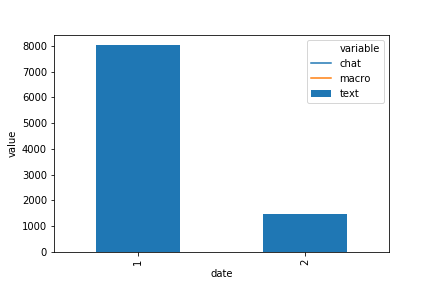

In [553]:
#number of tickets that include macro responses for labeling
df.groupby('t_id')['text'].nunique().value_counts().plot.bar()

In [554]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

In [559]:
ttdf = df[['t_created','text']].copy()

In [572]:
ttdf['date'] = ttdf.t_created.map(lambda x: x.date())

In [616]:
ts = ttdf.groupby(['date','text']).count().unstack(fill_value=0)

In [630]:
ts.columns = ['chat','macro']

In [632]:
ts.head()

chat  macro
date                   
2018-02-16     1      0
2018-02-20    18      0
2018-02-21    10      1
2018-02-22    14      1
2018-02-23    10      0

In [643]:
#long form for seaborn plotting
ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']).head()

date variable  value
0  2018-02-16     chat      1
1  2018-02-20     chat     18
2  2018-02-21     chat     10
3  2018-02-22     chat     14
4  2018-02-23     chat     10

Number of tickets per day that have macro responses. Ideal would be all?

<IPython.core.display.Javascript object>


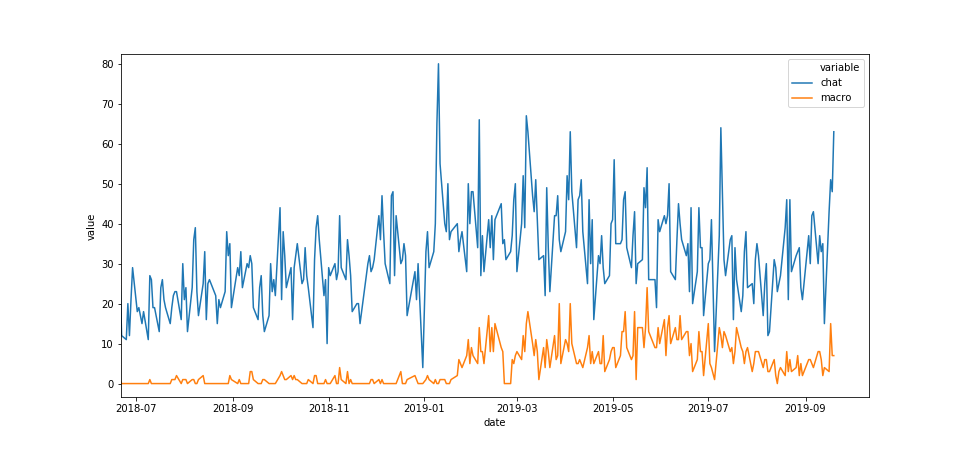

In [646]:
fig, ax= plt.subplots()
sns.lineplot(x='date', y='value',hue='variable',
             data=ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']),ax=ax)

Apply template phrases to larger dataset (need to verify accuracy of phrases)

In [447]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text         label  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...          None  
1  Hi Jeannie,\nThank you for contacting us. The ...      eligible  
2   \n(09:22:45 PM) denise: Do you allow electric...  not eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...  not eligible  
4   \n(09:21:52 PM) jeff wolf: what is best class...  not eligible

In [415]:
df['label'] = df.comment_text.map(phrase_label)

In [422]:
df.label.value_counts()/12845

not eligible    0.325963
eligible        0.036902
declined        0.005216
Name: label, dtype: float64

In [455]:
print(df[df.label=='not eligible'].comment_text[16])

 
(08:26:38 PM) Michelle Lee: Good Afternoon
I have a risk that is a lessors Risk
they have 2 Whole sales tenants - one is Jewelry and the other is a camera distributor
can we entertain this risk?
(08:27:30 PM) Michelle Lee: Hi Ashl'Y
(08:28:17 PM) Ashl'Y M.: hey Michelle the jewelry wholesale is okay
(08:28:24 PM) Ashl'Y M.: let me check on the camera
(08:28:26 PM) Ashl'Y M.: One moment please
(08:28:28 PM) Michelle Lee: thank you
(08:33:06 PM) Ashl'Y M.: how much space does the camera occupy
(08:33:54 PM) Michelle Lee: the total sq ft for the building is 10,000
Jewelry - 7,000
Camera Distributor - 3,000
(08:37:34 PM) Ashl'Y M.: okay unfortunately we wouldnt be able to write this because of the camera
(08:37:42 PM) Michelle Lee: thank you for trying
(08:37:44 PM) Michelle Lee: have a great day
(08:37:51 PM) Ashl'Y M.: you as well



## Labels of outcome

timestamps of automated responses

## Topic analysis

In [8]:
print(df.comment_text[0])

 
(09:57:41 PM) Jeannie: Hi
(09:58:11 PM) Shane C.: Hi Jeannie
(09:58:13 PM) Shane C.: How are you?
(09:58:22 PM) Jeannie: HI Shane
(09:58:50 PM) Jeannie: In reg to quote for "Fresh Donuts Inc"
(09:58:58 PM) Jeannie: they are bakery with cooking
(09:59:06 PM) Jeannie: not sure what's the best class I should go with
(09:59:47 PM) Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops
(09:59:53 PM) Jeannie: not sure if this is appropriate?
(10:00:00 PM) Jeannie: there is no specific bakery with cooking
(10:00:11 PM) Shane C.: Bakeries-Retail-With Baking on Premises 71311
(10:00:37 PM) Shane C.: I think this would be the best class code under processing and servicing
(10:01:12 PM) Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
(10:02:47 PM) Jeannie: Have a great day. TY
(10:03:07 PM) Shane C.: My pleasure. Is there anything else I can help with at the moment?
(10:03:19 PM) Jeannie: I'm good now. TY :)
(10:03:39

Remove timestamps and names(for now)

In [1072]:
print(re.sub(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)', '', df.comment_text[0]))

 
 Jeannie: Hi
 Shane C.: Hi Jeannie
 Shane C.: How are you?
 Jeannie: HI Shane
 Jeannie: In reg to quote for "Fresh Donuts Inc"
 Jeannie: they are bakery with cooking
 Jeannie: not sure what's the best class I should go with
 Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops
 Jeannie: not sure if this is appropriate?
 Jeannie: there is no specific bakery with cooking
 Shane C.: Bakeries-Retail-With Baking on Premises 71311
 Shane C.: I think this would be the best class code under processing and servicing
 Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
 Jeannie: Have a great day. TY
 Shane C.: My pleasure. Is there anything else I can help with at the moment?
 Jeannie: I'm good now. TY :)
 Shane C.: Any time. Enjoy the rest of your night :)


In [1074]:
names = [df.iloc[0].a_name, df.iloc[0].r_name]
#logic to catch first names
for n in names:
    split = n.split(' ')
    if len(split)>1:
        names.append(split[0])
print(re.sub('|'.join(names),'',df.comment_text[0]))

 
(09:57:41 PM) : Hi
(09:58:11 PM) : Hi 
(09:58:13 PM) : How are you?
(09:58:22 PM) : HI 
(09:58:50 PM) : In reg to quote for "Fresh Donuts Inc"
(09:58:58 PM) : they are bakery with cooking
(09:59:06 PM) : not sure what's the best class I should go with
(09:59:47 PM) : I choose on buz category for Restaurant fast food, class as Donut shops
(09:59:53 PM) : not sure if this is appropriate?
(10:00:00 PM) : there is no specific bakery with cooking
(10:00:11 PM) : Bakeries-Retail-With Baking on Premises 71311
(10:00:37 PM) : I think this would be the best class code under processing and servicing
(10:01:12 PM) : How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
(10:02:47 PM) : Have a great day. TY
(10:03:07 PM) : My pleasure. Is there anything else I can help with at the moment?
(10:03:19 PM) : I'm good now. TY :)
(10:03:39 PM) : Any time. Enjoy the rest of your night :)


Drop macros, merge tickets, remove timestamps/names/punctuation/whitespace

In [823]:
#After dropping tickets that are just macros, how many ticket IDs contain multiple chats?
df[df.text=='chat'].groupby('t_id')['comment_text'].count().value_counts()

1     8287
2      845
3      202
4       77
5       27
6       25
7        7
9        4
10       3
8        2
15       1
13       1
11       1
16       1
Name: comment_text, dtype: int64

In [11]:
import string

In [9]:
#output one column
def preprocess_df_grp(grp):
    d = {}
    #merge comments for the same ticket id
    text = '\n'.join(grp['comment_text'])
    #remove timestamp/name
    text = re.sub(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)',
                  '', text)
    #remove names of agent or customer
    names = list(set(grp['a_name']).union(set(grp['r_name'])))
    #logic to catch first names
    for n in names:
        split = n.split(' ')
        if len(split)>1:
            names.append(split[0])
    text = re.sub('|'.join(names),'',text)
    #remove excess whitespace
    text = re.sub(' +', ' ',text).strip()
    #remove punctuation
    text = re.sub(r"[{}]".format(string.punctuation),'',text)
    d['cleaned'] = text.replace('\n','')
    
    return pd.Series(d, index=['cleaned'])

Apply merge & preprocessing to 'chat' tickets only

In [13]:
merged_chat_comments = \
df[df.text=='chat'].groupby('t_id').apply(preprocess_df_grp)

In [14]:
merged_chat_comments.index.size

9483

Spot check sample (note chat names and database requester names are different)

In [15]:
df[df.t_id=='10021']

t_id           t_created          r_name          r_id          a_id  \
11955  10021 2018-05-24 15:01:56  Derrick Durham  115002954132  116469520771   

          a_name            subject  \
11955  Manaan A.  Chat with Derrick   

                                            comment_text  text  
11955   \n(03:01:16 PM) Derrick: I am getting a decli...  chat

In [16]:
print(df.groupby('t_id')['comment_text'].agg(lambda x: '\n'.join(x)).iloc[8])

 
(03:01:16 PM) Derrick: I am getting a decline for crime on quote for Tacos Del Julio. Anyway we can bypass this?
(03:01:55 PM) Manaan: Hi Derrick
(03:02:31 PM) Derrick: Howdy Manaan. Everybody loves tacos. Hopefully you can help me get this taco shop a quoote.
(03:03:13 PM) Derrick: Note, this location is about three blocks from a mall.
(03:03:37 PM) Derrick: Tacos Del Julio, in case I wasn't clear on what quote was declined for crime.
(03:03:42 PM) Manaan: Thank you, one moment
(03:04:37 PM) Manaan: At this time we do not make exceptions for the crime score
(03:06:10 PM) Derrick: Okay. We'll shut this one down then. Thank you sir.
(03:06:18 PM) Manaan: Have a great day


In [17]:
merged_chat_comments.iloc[8]['cleaned']

' I am getting a decline for crime on quote for Tacos Del Julio Anyway we can bypass this  Hi   Howdy  Everybody loves tacos Hopefully you can help me get this taco shop a quoote  Note this location is about three blocks from a mall  Tacos Del Julio in case I wasnt clear on what quote was declined for crime  Thank you one moment  At this time we do not make exceptions for the crime score  Okay Well shut this one down then Thank you sir  Have a great day'

### Preprocessing

In [18]:
import spacy

In [19]:
import nltk

In [20]:
# !python -m spacy download en

In [21]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [22]:
merged_chat_comments.head()

cleaned
t_id                                                     
100037   Good Afternoon  Good afternoon How are you to...
100052   hi  Hi  How are you today  Hi  I am well How ...
100077   Hello I am having a hard time classifying a r...
100094   Does Attune write for a virtual realty game b...
100130   Hello please advise  Visitor uploaded 2pdfURL...

In [1043]:
# set(spacy.lang.en.stop_words.STOP_WORDS)

In [25]:
from gensim.utils import simple_preprocess

In [1099]:
# def token_stop(text):
#     #remove accents, keep words 2-15 chars, lower, remove stopwords
#     return [token for token in simple_preprocess(text, deacc=True) if token not in spacy.lang.en.stop_words.STOP_WORDS]
#     return tokens

In [43]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(text):
#     return [word for word in simple_preprocess(text) if word not in stop_words]

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [89]:
#remove punct, spaces, stopwords (spacy), lemmatize, lower
def keep_token(t):
    return not (t.is_space or t.is_stop or len(t)<2 or len(t)>15)
#     return not (t.is_space or t.is_stop)

def lemmatize_doc(doc):
    return [t.lemma_.lower() for t in doc if keep_token(t)]

In [90]:
docs = [lemmatize_doc(nlp(doc)) for doc in merged_chat_comments.cleaned.values]

In [91]:
merged_chat_comments.cleaned[0]

' Good Afternoon  Good afternoon How are you today   I wanted to know if we can entertain the classcode 9028 for a WC quote  Could you please clarify what class that is and what risk you mean to attach it to  There is no risk that is attributed to it is for building operation dwelling NOC  I think it is more of a janitorial class  Ok What state are you trying to quote in  NY  Ok Can you give me a quick moment to check on this for you  Sure  There is an appetite for this class code in NY  great thank you very much  Youre welcome  Is there anything else I can help you with today  that should do it thank you  Sounds good  Please feel free to reach back out if you have any further questions'

In [92]:
' '.join(docs[0])

'good afternoon good afternoon today want know entertain classcode 9028 wc quote clarify class risk mean attach risk attribute build operation dwell noc think janitorial class ok state try quote ny ok quick moment check sure appetite class code ny great thank welcome help today thank sound good feel free reach question'

### Gensim 

In [981]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

//anaconda3/envs/zendesk/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
//anaconda3/envs/zendesk/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [1047]:
#create mapping between words and integer IDs
#https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary
docs_dict = Dictionary(docs)

In [1076]:
print(docs_dict)

Dictionary(28284 unique tokens: ['9028', 'afternoon', 'appetite', 'attach', 'attribute']...)


In [50]:
# sorted([(docs_dict[k],v) for k,v in docs_dict.dfs.items()], key=lambda x: x[1], reverse=True)

In [52]:
# [(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

In [ ]:
# docs_dict.filter_extremes(no_below=20, no_above=0.2)
# docs_dict.compactify()

In [1049]:
#convert each doc to BOW rep (counts of word IDs per doc)
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]

In [53]:
# docs_corpus[0]

In [1051]:
#transform  bow vectors to tfidf vectors
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]

In [1054]:
#view sample
[(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

[('dental', 0.5803287266730481),
 ('insuredbusiness', 0.26154100149465176),
 ('surgeriessedation', 0.26154100149465176),
 ('earlier', 0.25008827112587595),
 ('63981', 0.16536743993664402),
 ('owner', 0.16519462849918568),
 ('insure', 0.1640982076570375),
 ('ashly', 0.16346266312623767),
 ('bind', 0.1631676734607926),
 ('tenant', 0.15630612124484414),
 ('lessor', 0.14531138445969344),
 ('office', 0.1428583241502388),
 ('building', 0.14190627879127143),
 ('offices', 0.14102735953469592),
 ('chat', 0.12192079215897975),
 ('alright', 0.12102109700017323),
 ('risk', 0.11745236143687482),
 ('m', 0.10788539312817073),
 ('own', 0.09999984085607022),
 ('enter', 0.09769837618370808),
 ('check', 0.09685718175839256),
 ('hear', 0.09256795844007877),
 ('gl', 0.09158430130080662),
 ('case', 0.08999314692542257),
 ('quick', 0.08957415065422689),
 ('ok', 0.08913850038157992),
 ('look', 0.08887368137877899),
 ('need', 0.0838487173558619),
 ('eligible', 0.07770756042948618),
 ('go', 0.07712877123968771)

In [1055]:
#convert vectors in bow format to dense vectors dim n_doc x len_dict
docs_vecs  = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [1063]:
docs_vecs

array([[0.4047528 , 0.21239552, 0.07665578, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09729766, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1572759 , 0.3145518 ,
        0.3145518 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [1059]:
docs_vecs.shape

(9483, 28284)

- trim dictionary
- similarity search on TFIDF
- iterate with different stopwords, removing low weight TFIDF
- topic modeling on BOW with LDA, LSI
- include bigrams, trigrams

Sklearn

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [94]:
data = [' '.join(d) for d in docs]

In [126]:
tfidf = TfidfVectorizer(max_df=.9)

In [127]:
tfidf.fit(data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [129]:
# tfidf.vocabulary_

In [130]:
tfv = tfidf.fit_transform(data)

### KNN with cosine

In [132]:
from sklearn.neighbors import NearestNeighbors

In [133]:
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfv)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [135]:
data[0]

'good afternoon good afternoon today want know entertain classcode 9028 wc quote clarify class risk mean attach risk attribute build operation dwell noc think janitorial class ok state try quote ny ok quick moment check sure appetite class code ny great thank welcome help today thank sound good feel free reach question'

In [134]:
tfv[0]

<1x25045 sparse matrix of type '<class 'numpy.float64'>'
	with 41 stored elements in Compressed Sparse Row format>

In [167]:
for ind in nn.kneighbors(tfv[222])[1][0]:
    print('--------------------')
    print(data[ind])

--------------------
hello hi good morning hi need help classify risk prospect print plastic cup trinket company print company happen website view yes print shop hey printing class code category review site company manufacture medal different size unfortunately applicant mfg ineligible get manufacture state mg world importers inc information news info tab state import ineligible bop program ok thank
--------------------
hello print shop risk look bop need help determine eligible class here website application description operation print shop apparel sign decal hey hi use print shop processing service ok thank classification business new insured account screen enter preliminary info print shop digital print book naics 323111 awesome thank problem care
--------------------
bop tee shirt laser printing business hi good morning know printing class code let double check laser print moment print print tee shirt happen website review small business insured class code 71912 print processing ca

In [164]:
merged_chat_comments.iloc[1000]

cleaned    ZHang helklo ZHang hello  Hi  ZHang insured se...
Name: 115844, dtype: object

In [165]:
df[df.t_id=='115844']

t_id           t_created      r_name          r_id          a_id  \
1985  115844 2019-07-08 20:41:04  Ivan Zhang  378199108612  116469517831   

       a_name               subject  \
1985  Amit K.  Chat with Ivan ZHang   

                                           comment_text  text  
1985   \n(08:40:50 PM) Ivan ZHang: helklo\n(08:40:52...  chat

### Kmeans on TFIDF

In [72]:
from sklearn.cluster import KMeans

In [77]:
inertia_list = []
K = range(5,6)
for k in K:
    print("k={}--------------".format(k))
    km = KMeans(n_clusters=k)
    km = km.fit(tfv)
    inertia_list.append(km.inertia_)

k=5--------------


KeyboardInterrupt: 

In [ ]:
K = range(3,10)

In [ ]:
plt.plot(K, inertia_list, 'bx-')
plt.xlabel('k')
plt.ylabel('Cluster Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

widget visualization for cluster content

In [ ]:
#preprocess, tokenize (bigrams, trigrams, vectorize, transform (tfidf, lsi, lda), cluster/classify

### Evaluation of clusters

## Tickets JSON

In [504]:
query = '''
select * from zendesk_tickets_json where ticket_id='8960' limit 1;
'''

sample_ticket_json = psql_load(query)['full_json'][0]

In [505]:
import json

In [510]:
json.loads(sample_ticket_json)['ticket'].keys()

dict_keys(['submitter_id', 'forum_topic_id', 'subject', 'follower_ids', 'external_id', 'due_at', 'is_public', 'requester_id', 'organization_id', 'allow_channelback', 'satisfaction_rating', 'url', 'created_at', 'group_id', 'id', 'tags', 'problem_id', 'assignee_id', 'type', 'brand_id', 'recipient', 'status', 'priority', 'has_incidents', 'email_cc_ids', 'custom_fields', 'updated_at', 'description', 'collaborator_ids', 'via', 'raw_subject', 'followup_ids', 'sharing_agreement_ids', 'fields'])